In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import json
import os

# Preprocessing

Scrape web_summary.html results, run CellBender

#### Cellranger summaries

In [4]:
df1s = []
df2s = []

htmldir = '/home/ubuntu/data/cxcr4-pdac/cellranger_summary/'
summaries = [i for i in os.listdir(htmldir) if i.endswith('.html')]
for file in summaries:
    path = os.path.join(htmldir, file)
    sample = os.path.basename(file).split('_summary')[0]
    f = open(path, "r")


    contents = f.read()
    soup = BeautifulSoup(contents, 'html.parser')

    res = soup.find('script')
    json_str = res.contents[0][res.contents[0].index('{'):]
    json_object = json.loads(json_str)

    cell_tbl = json_object['summary']['summary_tab']['cells']['table']['rows']
    mapping_tbl = json_object['summary']['summary_tab']['mapping']['table']['rows']
    pipeline_info_tbl = json_object['summary']['summary_tab']['pipeline_info_table']['rows']
    filter_cell_table = lambda x: [i[1] for i in cell_tbl if i[0] == x][0]
    filter_mapping_table = lambda x: [i[1] for i in mapping_tbl if i[0] == x][0]
    filter_pipeline_table = lambda x: [i[1] for i in pipeline_info_tbl if i[0] == x][0]

    n_cells = filter_cell_table('Estimated Number of Cells')
    frac_reads_in_cells = filter_cell_table('Fraction Reads in Cells')
    mean_reads_per_cell = filter_cell_table('Mean Reads per Cell')
    median_umi_per_cell = filter_cell_table('Median UMI Counts per Cell')
    median_genes_per_cell = filter_cell_table('Median Genes per Cell')
    n_genes_total = filter_cell_table('Total Genes Detected')
    reads_mapped_to_genome = filter_mapping_table('Reads Mapped to Genome')
    reads_mapped_conf_to_genome = filter_mapping_table('Reads Mapped Confidently to Genome')
    reads_mapped_conf_to_txome = filter_mapping_table('Reads Mapped Confidently to Transcriptome')
    txome = f"{filter_pipeline_table('Transcriptome')}: {filter_pipeline_table('Reference Path')}"
    chemistry = filter_pipeline_table('Chemistry')

    df1 = pd.DataFrame({
        'sample': [sample],
        'n_cells': [n_cells],
        'frac_reads_in_cells': [frac_reads_in_cells],
        'mean_reads_per_cell': [mean_reads_per_cell],
        'median_umi_per_cell': [median_umi_per_cell],
        'median_genes_per_cell': [median_genes_per_cell],
        'n_genes_total': [n_genes_total],
        'reads_mapped_to_genome': [reads_mapped_to_genome],
        'reads_mapped_conf_to_genome': [reads_mapped_conf_to_genome],
        'reads_mapped_conf_to_txome': [reads_mapped_conf_to_txome],
        'txome': [txome],
        'chemistry': [chemistry]
    })

    df2 = pd.DataFrame(json_object['summary']
                                ['alarms']
                                ['alarms'])#[['level', 'raised','title',  'message', 'formatted_value']]
    df2.insert(loc = 0,
            column = 'sample',
            value = sample)
    
    df1s.append(df1)
    df2s.append(df2)

df1 = pd.concat(df1s).sort_values('sample').reset_index(drop=True)
df2 = pd.concat(df2s).sort_values('sample').reset_index(drop=True)

df1.to_csv('/home/ubuntu/data/cxcr4-pdac/cellranger_summary/cellsummary.tsv', sep='\t')
df2.to_csv('/home/ubuntu/data/cxcr4-pdac/cellranger_summary/errorsummary.tsv', sep='\t')

#### Cellbender Processing

In [ ]:
# Follow CellBender's instructions for installing it into its own env

# conda activate cellbender

for i in {18..40}
do
    if [[  $i -ne 25 ]]
    then
        samplenum="GM${i}"
        datadir="/home/ubuntu/data/cxcr4-pdac"
        cellsummary="${datadir}/cellranger_summary/cellsummary.tsv"
        ncells=$(grep "${samplenum}" "${cellsummary}" | awk '{print $3}' | tr -d ',' | awk 'END {printf "%.0f\n", $1*0.8}')
        indir="${datadir}/raw_matrix"
        outdir="${datadir}/cellbender_matrix"
        donefile="${outdir}/${samplenum}.done.checkpoint"

        echo "Starting on sample ${samplenum}" | ts '[%Y-%m-%d %H:%M:%S]'

        if [ ! -f "${donefile}" ]
        then
            cellbender remove-background \
                --input "${indir}/${samplenum}_raw_feature_bc_matrix.h5" \
                --output "${outdir}/${samplenum}_cellbender.h5" \
                --expected-cells "${ncells}" \
                --total-droplets-included 15000 \
                --epochs 300 \
                --cuda \
                2>&1 | ts '[%Y-%m-%d %H:%M:%S]' \
                > "${outdir}/${samplenum}.log.txt" && \
                    touch "${donefile}"
            echo "Finished ${samplenum}" | ts '[%Y-%m-%d %H:%M:%S]'
        else
            echo "Already done with ${samplenum}. Skipping." | ts '[%Y-%m-%d %H:%M:%S]'
        fi 
    fi
done


In [ ]:
projectdir="/home/ubuntu/projects/edsouza-summer2023/cxcr4-pdac"
datadir="/home/ubuntu/data/cxcr4-pdac"
cellbender="${datadir}/cellbender_matrix"

for i in {18..40}
do
    if [[  $i -ne 25 ]]
    then
        mkdir -p "${cellbender}/GM${i}"
        find "${cellbender}" -type f -iname "*GM$i*" | xargs -I '{}' mv  '{}' "${cellbender}/GM${i}"
    fi
done

# aws s3 cp ${cellbender}/ s3://cxcr4-pdac/cellbender/ --recursive

# Post Cellbender

QC, Scrublet, Seurat

In [1]:
%load_ext rpy2.ipython

In [8]:
%%R

library(Seurat)
library(dplyr)

dfs <- list()
for (i in seq(18, 40)) {
    if (i == 25) next;
    print(i)
    smpl <- paste0('GM', i)

    f1 <- paste0('/home/ubuntu/data/cxcr4-pdac/raw_matrix/GM', 
                 i, '_raw_feature_bc_matrix.h5')
    f2 <- paste0('/home/ubuntu/data/cxcr4-pdac/cellbender_matrix/GM', i,'/GM', 
                 i, '_cellbender.h5')
    f3 <- paste0('/home/ubuntu/data/cxcr4-pdac/cellbender_matrix/GM', i,'/GM',  
                 i, '_cellbender_filtered.h5')

    html_summary <- read.table('/home/ubuntu/data/cxcr4-pdac/cellranger_summary/cellsummary.tsv', sep='\t', header=T, quote="")
    ncell_html_pred <- html_summary %>% filter(sample==smpl) %>% .$n_cells


    obj <- Read10X_h5(f1) %>% CreateSeuratObject(min.cells=1, min.features=200)  # Filtering is important!
    md <- obj@meta.data
    raw_mean <- mean(md$nFeature_RNA)
    raw_median <- median(md$nFeature_RNA)
    ncells_raw <- dim(md)[1]
    md <- md[md$nCount_RNA != 0, ]
    raw_nonzero_mean <- mean(md$nFeature_RNA)
    raw_nonzero_median <- median(md$nFeature_RNA)
    ncells_raw_nonzero <- dim(md)[1]
    
    obj <- Read10X_h5(f2) %>% CreateSeuratObject(min.cells=1, min.features=200)
    md <- obj@meta.data
    cellbender_mean <- mean(md$nFeature_RNA)
    cellbender_median <- median(md$nFeature_RNA)
    ncells_cellbender <- dim(md)[1]
    md <- md[md$nCount_RNA != 0, ]
    cellbender_nonzero_mean <- mean(md$nFeature_RNA)
    cellbender_nonzero_median <- median(md$nFeature_RNA)
    ncells_cellbender_nonzero <- dim(md)[1]
    
    obj <- Read10X_h5(f3) %>% CreateSeuratObject(min.cells=1, min.features=200)
    md <- obj@meta.data
    cellbender_filtered_mean <- mean(md$nFeature_RNA)
    cellbender_filtered_median <- median(md$nFeature_RNA)
    ncells_cellbender_filtered <- dim(md)[1]
    md <- md[md$nCount_RNA != 0, ]
    cellbender_filtered_nonzero_mean <- mean(md$nFeature_RNA)
    cellbender_filtered_nonzero_median <- median(md$nFeature_RNA)
    ncells_cellbender_filtered_nonzero <- dim(md)[1]

    
    dfs[[i]] <- data.frame(
        sample=smpl, ncell_html_pred=ncell_html_pred,
        ncells_raw=ncells_raw, ncells_raw_nonzero=ncells_raw_nonzero,
        ncells_cellbender=ncells_cellbender, ncells_cellbender_nonzero=ncells_cellbender_nonzero,
        ncells_cellbender_filtered=ncells_cellbender_filtered, ncells_cellbender_filtered_nonzero=ncells_cellbender_filtered_nonzero,
        raw_mean=raw_mean, raw_nonzero_mean=raw_nonzero_mean,
        cellbender_mean=cellbender_mean, cellbender_nonzero_mean=cellbender_nonzero_mean,
        cellbender_filtered_mean=cellbender_filtered_mean, cellbender_filtered_nonzero_mean=cellbender_filtered_nonzero_mean,
        raw_median=raw_median, raw_nonzero_median=raw_nonzero_median,
        cellbender_median=cellbender_median, cellbender_nonzero_median=cellbender_nonzero_median,
        cellbender_filtered_median=cellbender_filtered_median, cellbender_filtered_nonzero_median=cellbender_filtered_nonzero_median
        )
    rm(obj); rm(md); gc()
}

outdf <- dplyr::bind_rows(dfs)

outdf %>% write.table('/home/ubuntu/data/cxcr4-pdac/cellbender_matrix/cellbender_summary.tsv', sep='\t')

# !FIGURE
outdf %>% write.table('/home/ubuntu/data/cxcr4-pdac/figures/cellbender_summary.tsv', sep='\t')
outdf %>% head(5)

[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
  sample ncell_html_pred ncells_raw ncells_raw_nonzero ncells_cellbender
1   GM18           4,190       5598               5598              4805
2   GM19           5,843      55465              55465              4833
3   GM20           4,931       6630               6630              5381
4   GM21           2,318       3163               3163              2637
5   GM22             761       2886               2886              2110
  ncells_cellbender_nonzero ncells_cellbender_filtered
1                      4805                       4804
2                      4833                       4828
3                      5381                       5375
4                      2637                       2632
5                      2110                       2105
  ncells_cellbender_filtered_nonzero  raw_mean raw_nonzero_mean cellbender_mea

## Scrublet

In [7]:
import os
import scrublet as scr
import scanpy as sc
import pandas as pd
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# Data from https://archive.ph/kS8Gi
duplex_rates = pd.DataFrame(
    {
        'n_cells': [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
        'rate': [0.004, 0.008, 0.016, 0.023, 0.031, 0.039, 0.046, 0.054, 0.061, 0.069, 0.076]
    }
)
reg = LinearRegression().fit(duplex_rates[['n_cells']], duplex_rates[['rate']])
ct_tbl = pd.read_table('/home/ubuntu/data/cxcr4-pdac/cellbender_matrix/summary.tsv')

for i in tqdm(range(18, 40+1)):
    if i == 25:
        continue
    

    samplename = f'GM{i}'
    file = f'/home/ubuntu/data/cxcr4-pdac/cellbender_matrix/{samplename}/{samplename}_cellbender_filtered.h5'
    outdir = os.path.join('/home/ubuntu/data/cxcr4-pdac', 'scrublet')
    if not os.path.exists(outdir):
        os.makedirs(outdir, exist_ok=True)
    outpath = os.path.join(outdir, f'{samplename}_doublets.txt')
    donefile = os.path.join(outdir, f'{samplename}.done.checkpoint')

    if os.path.exists(donefile):
        continue


    obj = sc.read_10x_h5(file)
    n_cells = ct_tbl[ct_tbl['sample']==samplename].ncells_cellbender_nonzero.iloc[0]
    est_doublet_rate = reg.coef_[0][0] * n_cells + reg.intercept_[0]

    print(f'Running sample {samplename} with n_cells={n_cells} and doublet rate {est_doublet_rate}')
    scrub = scr.Scrublet(obj.X, expected_doublet_rate=est_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=1, 
                                                              min_cells=1, 
                                                              min_gene_variability_pctl=50, 
                                                              n_prin_comps=20)

    with open(outpath, 'w') as outfile:
        outfile.write('barcode\tpredicted_doublets\tdoublet_scores\n')
        for j in range(len(predicted_doublets)):
            outfile.write(f'{obj.obs.index[j]}\t{predicted_doublets[j]}\t{doublet_scores[j]}\n')

    with open(donefile, 'w') as f:
        f.write('')
    print(f'Done with {samplename}')


100%|██████████| 23/23 [00:00<00:00, 28934.91it/s]


In [18]:
%matplotlib inline

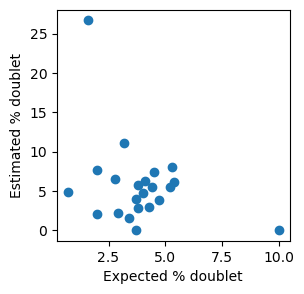

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

summary = pd.DataFrame({
    'Expected' : [4.1, 3.8, 4.4, 2.8, 2.0, 5.3, 0.7, 4.5, 5.4, 4.7, 5.2, 3.4, 2.9, 3.8, 4.3, 1.6, 2.0, 10.0, 4.0, 3.7, 3.2, 3.7],
    'Estimated' : [6.2, 5.8, 5.5, 6.5, 7.6, 8.1, 4.8, 7.4, 6.1, 3.8, 5.5, 1.6, 2.2, 2.8, 2.9, 26.7, 2.0, 0, 4.7, 4.0, 11.1, 0]
})

(fig, ax) = plt.subplots(1,1, figsize=(3,3))
ax.scatter(summary.Expected, summary.Estimated)
ax.set_xlabel('Expected % doublet')
ax.set_ylabel('Estimated % doublet')
plt.show()


In [14]:
import os
import pandas as pd

scrub_dir = '/home/ubuntu/data/cxcr4-pdac/scrublet'


dfs = []
for file in os.listdir(scrub_dir):
  if file.endswith('.txt'):
    samplename = os.path.basename(file).split('_doublets')[0]
    doublet_data = pd.read_csv(os.path.join(scrub_dir, file), sep='\t')
    preds = doublet_data['predicted_doublets']
    doublet_freq = sum(preds)/len(preds)
    dfs.append(pd.DataFrame({'Sample': [samplename], 'Doublet_freq': [doublet_freq]}))
dfs = pd.concat(dfs)
dfs.to_csv('/home/ubuntu/data/cxcr4-pdac/figures/scrublet_summary.tsv', sep='\t')

In [12]:
dfs

,Sample,Doublet_freq
0,GM22,0.003581
0,GM33,0.000709
0,GM40,0.000000
0,GM18,0.017655
0,GM38,0.000832
0,GM27,0.010100
0,GM28,0.000493
0,GM20,0.013684
0,GM31,0.001320
0,GM36,0.000000
